In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stat
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab 
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error



# data cleaning

In [3]:
df = pd.read_csv('/kaggle/input/bengaluru-house-price-data/Bengaluru_House_Data.csv')
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


#### removing spaces from locations

In [6]:
df['area_type'] = df['area_type'].apply(lambda x: x.replace(" ", "_"))
df1 = df.drop(['society','availability','area_type'],axis=1)

#### droping na 

In [7]:
df1 = df1.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12710 entries, 0 to 13319
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    12710 non-null  object 
 1   size        12710 non-null  object 
 2   total_sqft  12710 non-null  object 
 3   bath        12710 non-null  float64
 4   balcony     12710 non-null  float64
 5   price       12710 non-null  float64
dtypes: float64(3), object(3)
memory usage: 695.1+ KB


#### droping duplicates

In [8]:
df1 = df1.drop_duplicates()
df1.duplicated().sum()

0

In [9]:
df2 = df1
df2['rooms'] = df2['size'].apply(lambda x: float(x.split(' ')[0]))
df2 = df2.drop('size', axis=1)
df2

,location,total_sqft,bath,balcony,price,rooms
0,Electronic City Phase II,1056,2.0,1.0,39.07,2.0
1,Chikka Tirupathi,2600,5.0,3.0,120.00,4.0
2,Uttarahalli,1440,2.0,3.0,62.00,3.0
3,Lingadheeranahalli,1521,3.0,1.0,95.00,3.0
4,Kothanur,1200,2.0,1.0,51.00,2.0
...,...,...,...,...,...,...
13312,Bellandur,1262,2.0,2.0,47.00,2.0
13314,Green Glen Layout,1715,3.0,3.0,112.00,3.0
13315,Whitefield,3453,4.0,0.0,231.00,5.0
13317,Raja Rajeshwari Nagar,1141,2.0,1.0,60.00,2.0


In [10]:
df2 = df2.drop_duplicates()

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11966 entries, 0 to 13318
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    11966 non-null  object 
 1   total_sqft  11966 non-null  object 
 2   bath        11966 non-null  float64
 3   balcony     11966 non-null  float64
 4   price       11966 non-null  float64
 5   rooms       11966 non-null  float64
dtypes: float64(4), object(2)
memory usage: 654.4+ KB


In [12]:
def digitalize(x):
    if len(x.split('-')) == 1:
        try:
               return float(x)
        except Exception:
            pass
           
    elif len(x.split('-')) == 2:
        return (float(x.split('-')[0]) + float(x.split('-')[1])) / 2
    else:
        return float(x[0:5]) 


In [13]:
df2['total_sqft'] = df2['total_sqft'].apply(digitalize)

/tmp/ipykernel_33/3933934527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['total_sqft'] = df2['total_sqft'].apply(digitalize)


In [14]:
df2 = df2.dropna()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11924 entries, 0 to 13318
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   location    11924 non-null  object 
 1   total_sqft  11924 non-null  float64
 2   bath        11924 non-null  float64
 3   balcony     11924 non-null  float64
 4   price       11924 non-null  float64
 5   rooms       11924 non-null  float64
dtypes: float64(5), object(1)
memory usage: 652.1+ KB


In [15]:
col = ['price','total_sqft','bath','balcony','rooms']
bins = [150,150,100,15,len(df2['rooms'].unique())]

In [16]:
def plot_data(df,feature):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.title(feature)
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

# Outlier removal 

In [17]:
df2['price_per_sqft'] = df2['price']*100000 / df2['total_sqft']

In [18]:
df8 = df2
df8.describe()

,total_sqft,bath,balcony,price,rooms,price_per_sqft
count,11924.000000,11924.000000,11924.000000,11924.000000,11924.000000,1.192400e+04
mean,1524.470737,2.636615,1.586464,108.217664,2.754864,6.987311e+03
std,1191.393605,1.245387,0.824734,135.022766,1.225360,2.331769e+04
min,5.000000,1.000000,0.000000,8.000000,1.000000,2.678298e+02
25%,1100.000000,2.000000,1.000000,50.000000,2.000000,4.285714e+03
50%,1270.000000,2.000000,2.000000,70.000000,3.000000,5.433830e+03
75%,1650.000000,3.000000,2.000000,116.250000,3.000000,7.266687e+03
max,52272.000000,40.000000,3.000000,2912.000000,43.000000,2.300000e+06


In [19]:
df8 = df8[df8['total_sqft']/df8['rooms'] >= 300 ]
df8.describe()

,total_sqft,bath,balcony,price,rooms,price_per_sqft
count,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000,11282.000000
mean,1556.997878,2.527211,1.589080,107.385579,2.619926,6287.391250
std,1211.939961,1.022317,0.817056,137.681822,0.937751,4075.417914
min,300.000000,1.000000,0.000000,9.000000,1.000000,267.829813
25%,1107.207500,2.000000,1.000000,49.270000,2.000000,4236.492579
50%,1299.000000,2.000000,2.000000,70.000000,3.000000,5298.628776
75%,1683.000000,3.000000,2.000000,113.000000,3.000000,6896.551724
max,52272.000000,13.000000,3.000000,2912.000000,13.000000,176470.588235


In [20]:
df8 = df8[df8['bath'] <= df8['rooms'] + 2 ]
df8.describe()

,total_sqft,bath,balcony,price,rooms,price_per_sqft
count,11277.000000,11277.00000,11277.000000,11277.000000,11277.000000,11277.000000
mean,1555.426626,2.52514,1.588898,107.107662,2.619225,6283.665406
std,1207.348331,1.01750,0.817083,136.489606,0.937046,4065.861818
min,300.000000,1.00000,0.000000,9.000000,1.000000,267.829813
25%,1107.000000,2.00000,1.000000,49.270000,2.000000,4236.453202
50%,1298.000000,2.00000,2.000000,70.000000,2.000000,5298.507463
75%,1682.000000,3.00000,2.000000,113.000000,3.000000,6896.551724
max,52272.000000,13.00000,3.000000,2912.000000,13.000000,176470.588235


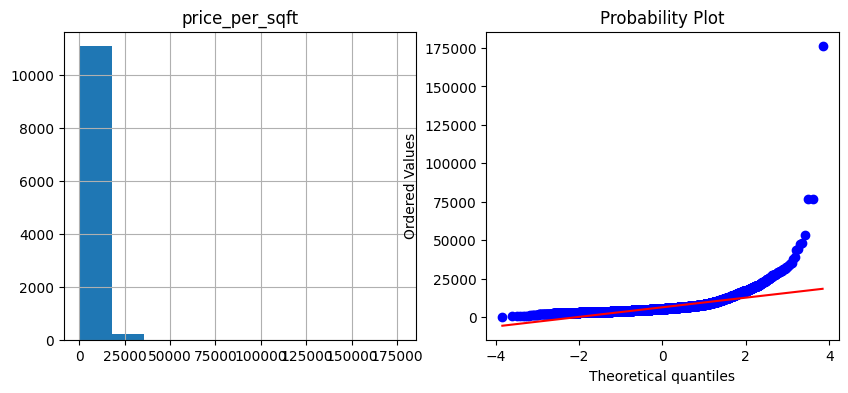

In [21]:
plot_data(df8,'price_per_sqft')

In [22]:
df8['log'] = np.log(df8['price_per_sqft'])
df8['sqrt'] = np.sqrt(df8['price_per_sqft'])
df8['inv'] = 1/(df8['price_per_sqft'])
df8['exp'] = df8['price_per_sqft']**(1/1.2)
df8['box'],_ = stat.boxcox(df8['price_per_sqft'])  # Adding 1 to ensure all values are positive



In [23]:
print(df8['box'].skew(),df8['log'].skew(),df8['sqrt'].skew(),df8['exp'].skew(),df8['inv'].skew() )

-0.18490862739839636 0.8504577719375335 2.4627101463821712 5.704153383301084 10.088859612654135


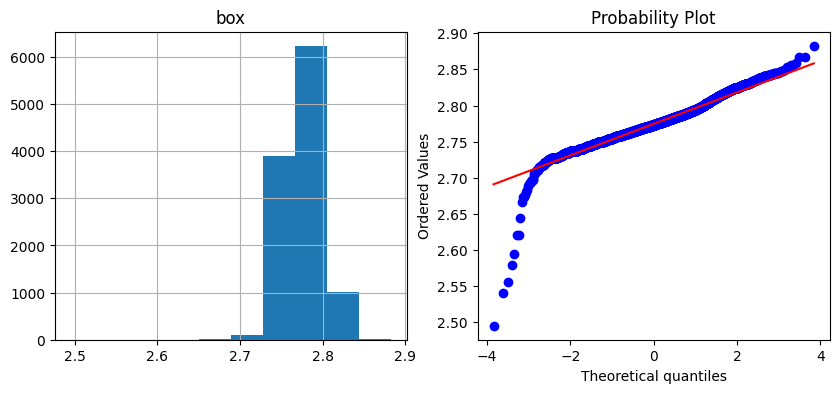

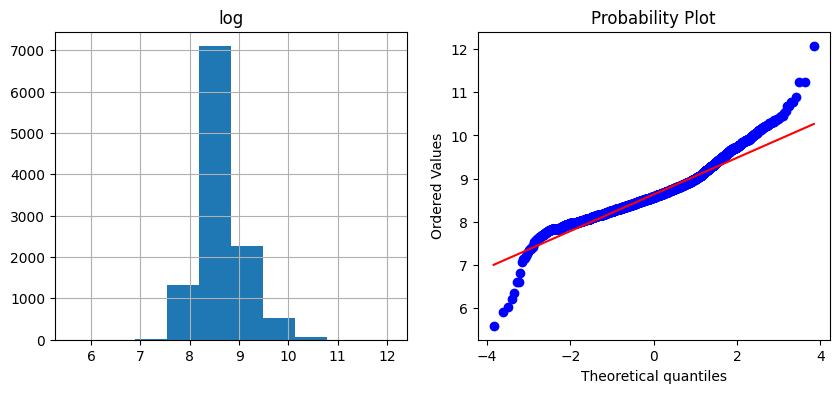

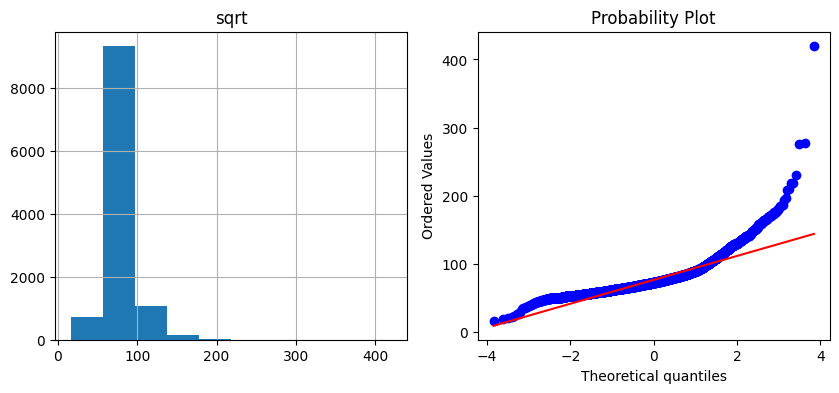

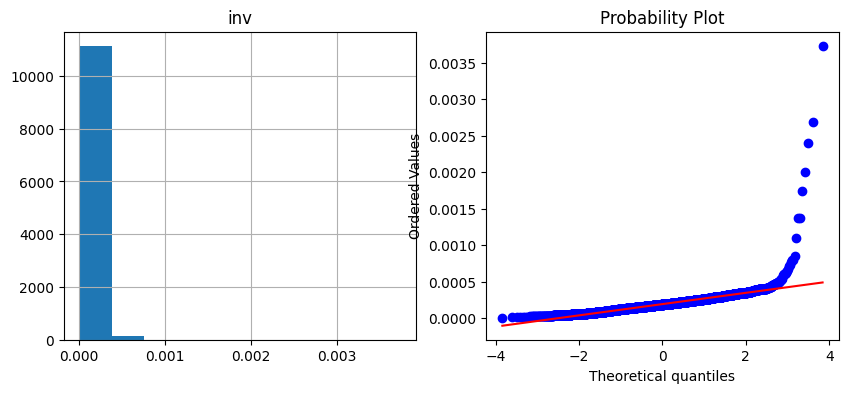

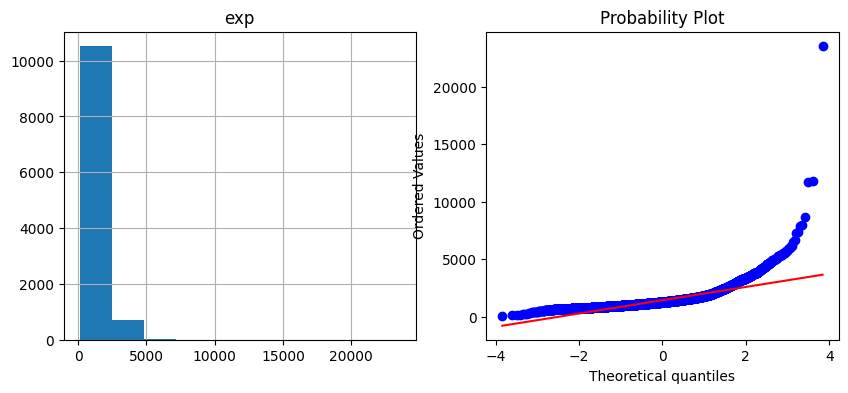

In [24]:
plot_data(df8,'box')
plot_data(df8,'log')
plot_data(df8,'sqrt')
plot_data(df8,'inv')
plot_data(df8,'exp')


In [25]:
grouped = df8.groupby('location')['total_sqft']
mean = grouped.transform('mean')
std = grouped.transform('std')
df8 = df8[(df8['box']>= mean - 1.5*std) & (df8['box']<= mean +1.5* std )]

In [26]:
df8.describe()

,total_sqft,bath,balcony,price,rooms,price_per_sqft,log,sqrt,inv,exp,box
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,1988.653214,2.573593,1.562771,139.678144,2.668831,6306.999783,8.617643,76.708858,0.000207,1438.048149,2.773221
std,3302.469350,1.200395,0.866719,276.088340,1.122344,4017.075636,0.493182,20.572040,0.000189,716.350141,0.027763
min,395.000000,1.000000,0.000000,10.000000,1.000000,267.829813,5.590352,16.365507,0.000029,105.491087,2.495356
25%,1100.000000,2.000000,1.000000,50.000000,2.000000,4251.752336,8.355086,65.205462,0.000150,1056.347067,2.760936
50%,1322.000000,2.000000,2.000000,70.000000,3.000000,5200.000000,8.556414,72.111026,0.000192,1249.307804,2.772175
75%,1717.250000,3.000000,2.000000,114.250000,3.000000,6666.666667,8.804875,81.649658,0.000235,1536.705400,2.785022
max,52272.000000,10.000000,3.000000,2912.000000,10.000000,35000.000000,10.463103,187.082869,0.003734,6119.604711,2.847761


In [27]:
dflog = df8.copy()
dfsqrt = df8.copy()
dfinv = df8.copy()
dfexp = df8.copy()
dfbx = df8.copy()

In [28]:
col = ['price','total_sqft']
for i,c in enumerate(col):
    dflog[c] = np.log(dflog[c] )
    dfsqrt[c] = np.sqrt(dfsqrt[c])
    dfinv[c] = 1/(dfinv[c])
    dfexp[c] = dfexp[c]**(1/1.2)
    dfbx[c],parameters=stat.boxcox(dfbx[c])

In [29]:
print(dfbx['price'].skew() , dflog['price'].skew(),dfsqrt['price'].skew(),dfinv['price'].skew(),dfexp['price'].skew() )

-0.0886011555796771 1.114269785536737 3.582284592990316 2.935623715977555 5.44546701087405


In [30]:
print(dfbx['total_sqft'].skew() , dflog['total_sqft'].skew(),dfsqrt['total_sqft'].skew(),dfinv['total_sqft'].skew(),dfexp['total_sqft'].skew() )

-0.12977884534695752 1.6248167956231427 4.814202581503475 1.511794584520686 7.964223883440465


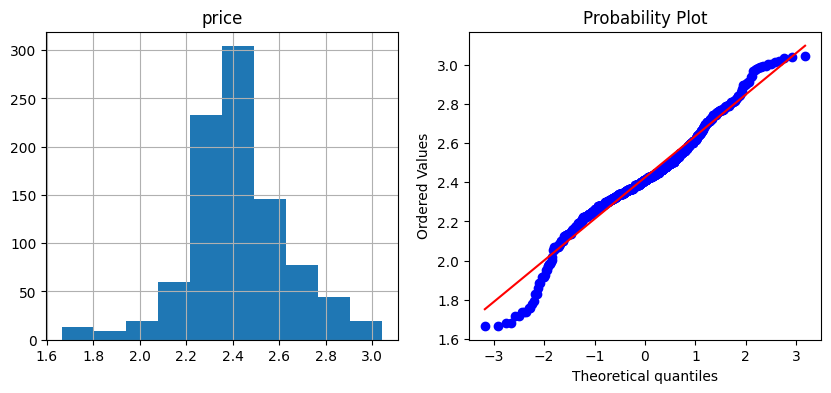

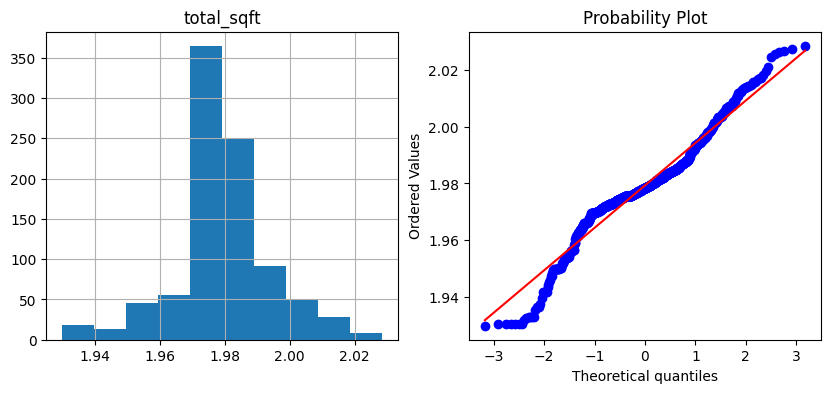

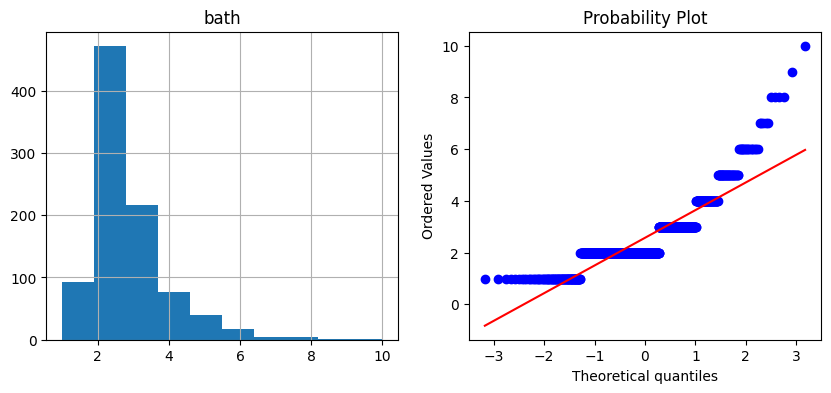

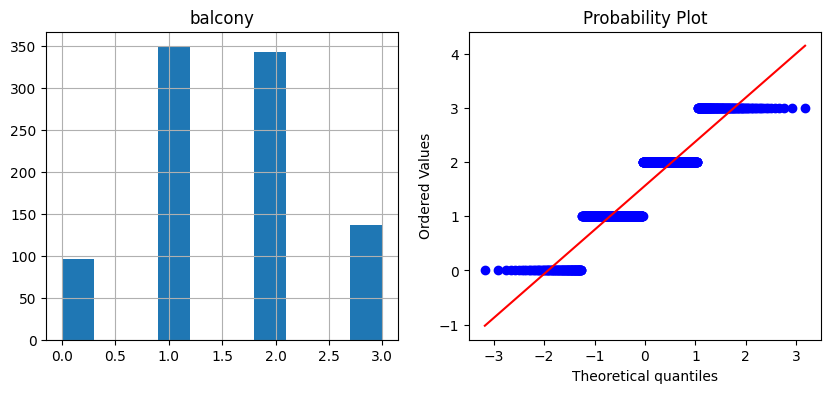

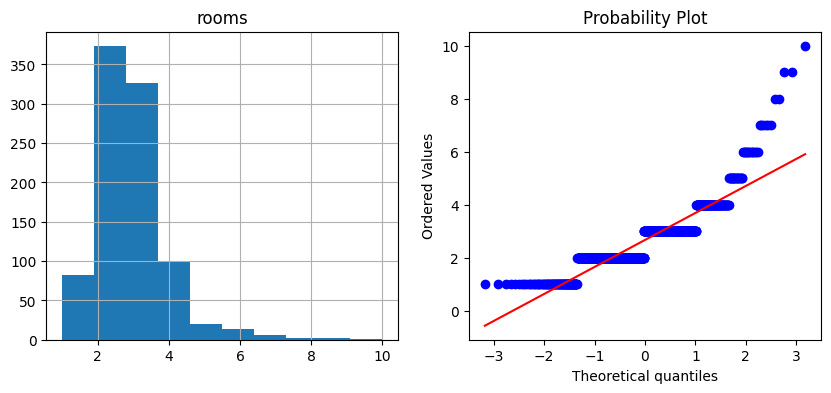

In [31]:
col = ['price','total_sqft','bath','balcony','rooms']

for i,c in enumerate(col):
    plot_data(dfbx,c)

In [32]:
df8['price'],_ = stat.boxcox(df8['price'])
#df8['total_sqft']= dfsqrt['total_sqft']
df8['total_sqft'],_= stat.boxcox(df8['total_sqft'])
#df8['total_sqft']=dfexp['total_sqft']

/tmp/ipykernel_33/2903167726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['price'],_ = stat.boxcox(df8['price'])
/tmp/ipykernel_33/2903167726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['total_sqft'],_= stat.boxcox(df8['total_sqft'])


In [33]:
df8.duplicated().sum()

0

In [34]:
df8 = df8.drop_duplicates()
df8

,location,total_sqft,bath,balcony,price,rooms,price_per_sqft,log,sqrt,inv,exp,box
4,Kothanur,1.975491,2.0,1.0,2.316170,2.0,4250.000000,8.354674,65.192024,0.000235,1055.984252,2.760912
28,Ramagondanahalli,1.974192,2.0,2.0,2.302221,2.0,4237.185056,8.351654,65.093664,0.000236,1053.330177,2.760738
30,Yelahanka,1.994296,4.0,0.0,2.648924,4.0,7515.151515,8.924676,86.689974,0.000133,1698.040786,2.790838
43,Yelahanka,1.954051,1.0,0.0,2.297211,1.0,7272.727273,8.891887,85.280287,0.000138,1652.270256,2.789270
54,Yelahanka,1.983772,2.0,3.0,2.429082,3.0,4687.500000,8.452655,68.465320,0.000213,1145.823523,2.766479
...,...,...,...,...,...,...,...,...,...,...,...,...
13283,Neeladri Nagar,1.990716,3.0,2.0,2.512712,3.0,4879.204169,8.492737,69.851300,0.000205,1184.743022,2.768703
13284,Bannerghatta Road,1.968570,2.0,1.0,2.350076,2.0,5876.288660,8.678681,76.656954,0.000170,1383.309208,2.778633
13294,Sultan Palaya,1.991673,3.0,3.0,2.446742,4.0,3636.363636,8.198739,60.302269,0.000275,927.305328,2.751659
13301,Kothanur,1.981146,3.0,3.0,2.415784,3.0,4917.469051,8.500549,70.124668,0.000203,1192.480711,2.769133


In [35]:
df8['location'].value_counts()

location
Yelahanka                 199
Bannerghatta Road         140
Kothanur                   51
Malleshwaram               47
Ramagondanahalli           45
                         ... 
CQAL Layout                 2
Govindaraja Nagar Ward      2
Bettahalsoor                2
St. John's Road             2
Ashok Nagar                 2
Name: count, Length: 63, dtype: int64

In [36]:
counts = df8.location.value_counts()
other = np.array(counts[counts.values < 10].keys())

In [37]:
df8['locate'] = df8['location'].apply(lambda x: 'other' if x in other else x )

In [38]:
df8[df8['locate']=='other']

,location,total_sqft,bath,balcony,price,rooms,price_per_sqft,log,sqrt,inv,exp,box,locate
59,Govindaraja Nagar Ward,1.963462,2.0,2.0,2.276648,2.0,5357.142857,8.586186,73.192505,0.000187,1280.690997,2.773773,other
79,ISRO Layout,2.005142,6.0,3.0,2.708586,6.0,5681.818182,8.645027,75.377836,0.000176,1345.053143,2.776882,other
93,ISRO Layout,1.975491,4.0,2.0,2.609433,4.0,12916.666667,9.466274,113.651514,0.000077,2666.605129,2.814356,other
143,ISRO Layout,1.969605,2.0,1.0,2.365337,2.0,6000.000000,8.699515,77.459667,0.000167,1407.535559,2.779707,other
357,Bagalur Main Road,1.967852,2.0,2.0,2.310015,2.0,5263.157895,8.568486,72.547625,0.000190,1261.939882,2.772825,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13084,Nayandanahalli,1.970757,2.0,2.0,2.365337,2.0,5797.101449,8.665113,76.138699,0.000173,1367.757434,2.777930,other
13104,Church Street,1.997732,4.0,3.0,2.840255,4.0,18356.164384,9.817721,135.484923,0.000054,3573.975863,2.827449,other
13155,Doddabommasandra,1.983772,2.0,1.0,2.478109,2.0,5625.000000,8.634976,75.000000,0.000178,1333.834989,2.776356,other
13174,Kodbisanhalli,1.970007,2.0,1.0,2.374972,2.0,6126.482213,8.720376,78.271848,0.000163,1432.218615,2.780775,other


In [39]:
df8 = df8.drop('location',axis=1)

In [40]:
print(df8.duplicated().sum())
df8 = df8.drop_duplicates()


1


In [41]:
df8.index.isin( df2.index ).sum()

923

In [42]:
df9 = df8.copy()

In [43]:
df9.describe()

,total_sqft,bath,balcony,price,rooms,price_per_sqft,log,sqrt,inv,exp,box
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,1.979334,2.574215,1.563380,2.425297,2.669556,6308.415817,8.617752,76.715357,0.000207,1438.296158,2.773224
std,0.015282,1.200897,0.866991,0.215110,1.122736,4019.022760,0.493438,20.582245,0.000189,716.698821,0.027777
min,1.929894,1.000000,0.000000,1.666204,1.000000,267.829813,5.590352,16.365507,0.000029,105.491087,2.495356
25%,1.972748,2.000000,1.000000,2.311132,2.000000,4251.168224,8.354949,65.200983,0.000150,1056.226129,2.760928
50%,1.978410,2.000000,2.000000,2.409823,3.000000,5200.000000,8.556414,72.111026,0.000192,1249.307804,2.772175
75%,1.985638,3.000000,2.000000,2.538899,3.000000,6666.666667,8.804875,81.649658,0.000235,1536.705400,2.785022
max,2.028522,10.000000,3.000000,3.044654,10.000000,35000.000000,10.463103,187.082869,0.003734,6119.604711,2.847761


In [44]:
df9

,total_sqft,bath,balcony,price,rooms,price_per_sqft,log,sqrt,inv,exp,box,locate
4,1.975491,2.0,1.0,2.316170,2.0,4250.000000,8.354674,65.192024,0.000235,1055.984252,2.760912,Kothanur
28,1.974192,2.0,2.0,2.302221,2.0,4237.185056,8.351654,65.093664,0.000236,1053.330177,2.760738,Ramagondanahalli
30,1.994296,4.0,0.0,2.648924,4.0,7515.151515,8.924676,86.689974,0.000133,1698.040786,2.790838,Yelahanka
43,1.954051,1.0,0.0,2.297211,1.0,7272.727273,8.891887,85.280287,0.000138,1652.270256,2.789270,Yelahanka
54,1.983772,2.0,3.0,2.429082,3.0,4687.500000,8.452655,68.465320,0.000213,1145.823523,2.766479,Yelahanka
...,...,...,...,...,...,...,...,...,...,...,...,...
13283,1.990716,3.0,2.0,2.512712,3.0,4879.204169,8.492737,69.851300,0.000205,1184.743022,2.768703,Neeladri Nagar
13284,1.968570,2.0,1.0,2.350076,2.0,5876.288660,8.678681,76.656954,0.000170,1383.309208,2.778633,Bannerghatta Road
13294,1.991673,3.0,3.0,2.446742,4.0,3636.363636,8.198739,60.302269,0.000275,927.305328,2.751659,Sultan Palaya
13301,1.981146,3.0,3.0,2.415784,3.0,4917.469051,8.500549,70.124668,0.000203,1192.480711,2.769133,Kothanur


In [45]:
#t = pd.get_dummies(df9[['area_type','locate']],drop_first=True)*1
#t = pd.get_dummies(df9[['area_type','locate']]).drop(['locate_other','area_type_Built-up__Area'], axis=1) *1
t = pd.get_dummies(df9['locate'],drop_first=True)*1


In [46]:
t

,Banashankari Stage III,Banaswadi,Bannerghatta Road,Bommasandra Industrial Area,Devanahalli,ITPL,Kalyan nagar,Kothanur,Magadi Road,Malleshwaram,Mico Layout,Munnekollal,Neeladri Nagar,Ramagondanahalli,Sultan Palaya,Tindlu,Ulsoor,Yelahanka,other
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13283,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
13284,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
13301,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [47]:
t = t.reset_index(drop=True)
t

,Banashankari Stage III,Banaswadi,Bannerghatta Road,Bommasandra Industrial Area,Devanahalli,ITPL,Kalyan nagar,Kothanur,Magadi Road,Malleshwaram,Mico Layout,Munnekollal,Neeladri Nagar,Ramagondanahalli,Sultan Palaya,Tindlu,Ulsoor,Yelahanka,other
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
919,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
920,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
921,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#scaler = MinMaxScaler()
scaler = StandardScaler()
features = df9[['total_sqft','bath','balcony','rooms','price']]
f_scaled = scaler.fit_transform(features)
#f_scaled = features

In [49]:
f_scaled

array([[-0.25160485, -0.47841379, -0.65016358, -0.59668412, -0.50758296],
       [-0.33671126, -0.47841379,  0.50387677, -0.59668412, -0.57246449],
       [ 0.97959637,  1.18791046, -1.80420393,  1.18564416,  1.04015916],
       ...,
       [ 0.80783252,  0.35474834,  1.65791712,  1.18564416,  0.09974487],
       [ 0.11863109,  0.35474834,  1.65791712,  0.29448002, -0.04424922],
       [ 0.20764147,  0.35474834, -0.65016358,  0.29448002,  0.76460557]])

In [50]:
df10 = pd.DataFrame(f_scaled, columns=features.columns)
#df10= f_scaled
df10

,total_sqft,bath,balcony,rooms,price
0,-0.251605,-0.478414,-0.650164,-0.596684,-0.507583
1,-0.336711,-0.478414,0.503877,-0.596684,-0.572464
2,0.979596,1.187910,-1.804204,1.185644,1.040159
3,-1.655394,-1.311576,-1.804204,-1.487848,-0.595768
4,0.290526,-0.478414,1.657917,0.294480,0.017603
...,...,...,...,...,...
918,0.745222,0.354748,0.503877,0.294480,0.406596
919,-0.704788,-0.478414,-0.650164,-0.596684,-0.349877
920,0.807833,0.354748,1.657917,1.185644,0.099745
921,0.118631,0.354748,1.657917,0.294480,-0.044249


In [51]:
#df10= df10.reset_index(drop=True)
#df10

In [52]:
Y = df10['price']
Z = df10.drop('price',axis=1)
X = df10.drop(['price'],axis=1)


In [53]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

      feature       VIF
0  total_sqft  2.588228
1        bath  5.334112
2     balcony  1.113108
3       rooms  5.782252


In [54]:
X = pd.concat([X,t],axis=1)

In [55]:
print(X.shape,Y.shape,t.shape)

(923, 23) (923,) (923, 19)


In [56]:
score = cross_val_score(LinearRegression(),X,Y,cv=5)
print(score)
print(score.mean()*100)

[0.82248296 0.80685655 0.80012897 0.79828753 0.83932969]
81.34171393596617


In [57]:
score = cross_val_score(RandomForestRegressor(),X,Y,cv=5)
print(score)
print(score.mean()*100)

[0.81820819 0.8101935  0.77175197 0.81235583 0.81424362]
80.53506214777256
